In [1]:
import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt


In [121]:
def box(x, c1, c2):
    return np.where((x >= c1) & (x <= c2), 1, 0)

def double_slit_mask(x, c1, c2, ca, cb):
    return box(x, c1, c2) + box(x, ca, cb)

def sin_sample(x, freq, phase):
    return np.sin(2 * np.pi * freq * x + phase)

def generate_data_single_gate(rate, f_0, phase_0, box_width, padding):
    # box width, padding in seconds
    t = np.arange(0, padding*2 + box_width, 1/rate)
    pad_idx = np.argmin(np.abs(t-padding))
    c1 = t[pad_idx]
    c2 = t[-pad_idx]
    mask = box(t, c1, c2)
    t = t - (padding + box_width/2)
    signal = sin_sample(t, f_0, phase_0)
    data = signal * mask
    return t, data

def generate_data_double_gate(rate, f_0, phase_0, box_width, box_sep, pad):
    # box width, pad, etc in time units
    total_time = 2*pad+2*box_width+box_sep
    t = np.arange(0, total_time, 1/rate)
    c1 = t[np.argmin(np.abs(t-pad))]
    c2 = t[np.argmin(np.abs(t-(pad+box_width)))]
    ca = t[np.argmin(np.abs(t-(pad+box_width+box_sep)))]
    cb = t[np.argmin(np.abs(t-(pad+box_width+box_sep+box_width)))]
    mask = double_slit_mask(t, c1, c2, ca, cb)
    t = t - (pad + box_width/2)
    signal = sin_sample(t, f_0, phase_0)
    data = signal * mask
    return t, data

def add_noise(data, noise_level):
    noise = np.random.normal(0, noise_level, size=data.shape)
    return data + noise

def get_real_data(data_t, data_gate, want_noise=False):
    t_list = []
    data_list = []
    for i, t in enumerate(data_t):
        if data_gate[i] != 0:
            t_list.append(t)
            data_list.append(data_gate[i])
    if want_noise:
        data = add_noise(np.array(data_list), noise_level=0.1)
    else:
        data = np.array(data_list)
    return np.array(t_list), data


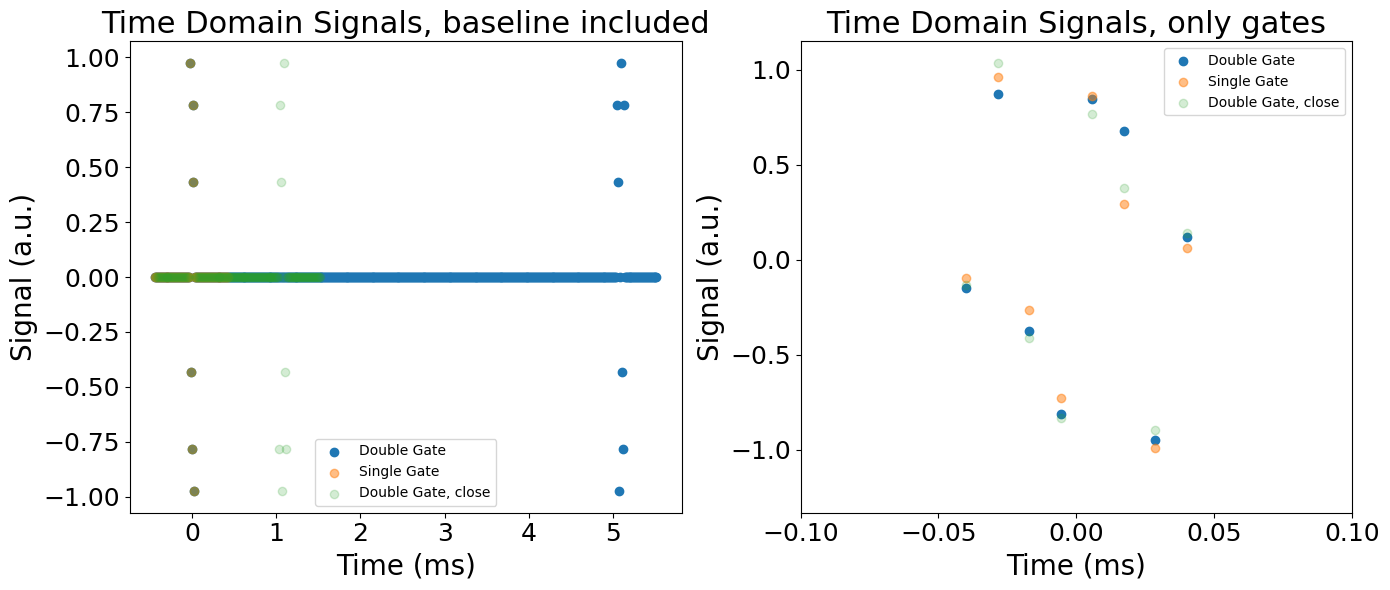

In [122]:
f_0 = 25e3
tau_0 = 1 / f_0
f_samp = f_0 * 3.5
width = 2 * tau_0
pad = 10 * tau_0
sep = 125 * tau_0
sep3 = tau_0 * 25

t_1, data_1 = generate_data_single_gate(f_samp, f_0, 0, width, pad)
t_2, data_2 = generate_data_double_gate(f_samp, f_0, 0, width, sep, pad)
t_3, data_3 = generate_data_double_gate(f_samp, f_0, 0, width, sep3, pad)


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].scatter(t_2*1e3, data_2,label='Double Gate')
ax[0].scatter(t_1*1e3, data_1,label='Single Gate', alpha=0.5)
ax[0].scatter(t_3*1e3, data_3,label='Double Gate, close', alpha=0.2)
ax[0].set_xlabel("Time (ms)")
ax[0].set_ylabel("Signal (a.u.)")
ax[0].legend()
ax[0].set_title("Time Domain Signals, baseline included")

real_time1, real_data1 = get_real_data(t_1, data_1, want_noise=True)
real_time2, real_data2 = get_real_data(t_2, data_2, want_noise=True)
real_time3, real_data3 = get_real_data(t_3, data_3, want_noise=True)

ax[1].scatter(real_time2*1e3, real_data2,label='Double Gate')
ax[1].scatter(real_time1*1e3, real_data1,label='Single Gate', alpha=0.5)
ax[1].scatter(real_time3*1e3, real_data3,label='Double Gate, close', alpha=0.2)
ax[1].set_xlabel("Time (ms)")
ax[1].set_ylabel("Signal (a.u.)")
ax[1].legend()
ax[1].set_title("Time Domain Signals, only gates")
ax[1].set_xlim(-.1,.1)
plt.tight_layout()

time domain size: 77, 77
dt: 0.01 ms, f_samp: 87.50 kHz, f_nyquist: 43.75 kHz
freq domain size: 38, 38
time domain size: 8, 8
dt: 0.01 ms, f_samp: 87.50 kHz, f_nyquist: 43.75 kHz
freq domain size: 4, 4


Text(0.5, 0, 'Frequency (kHz)')

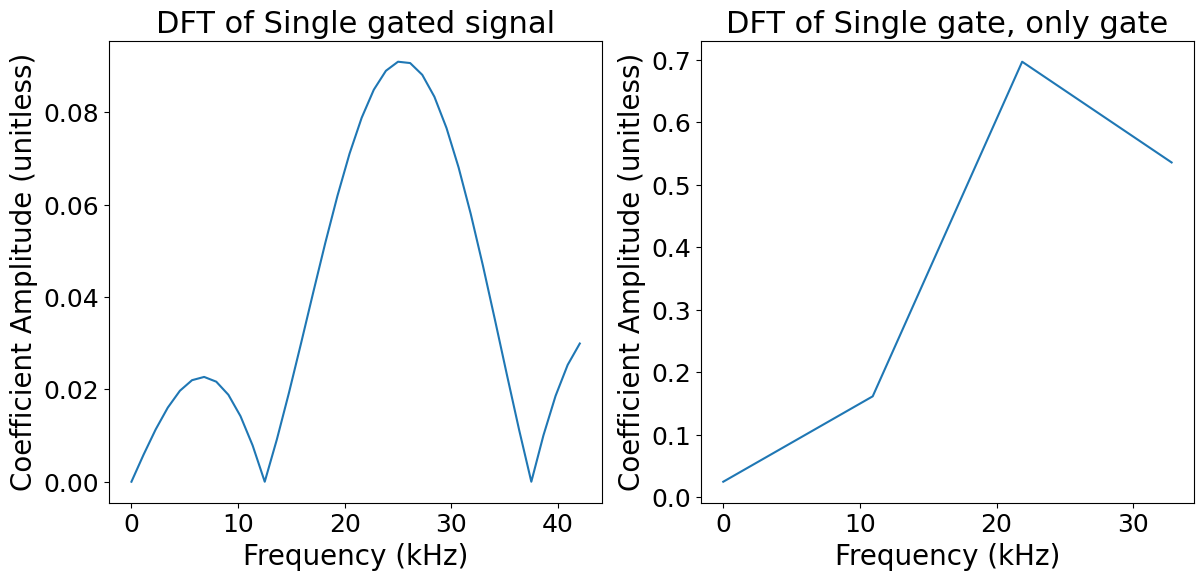

In [123]:
def fourier_transform(time, signal):
    'returns one sided normalized Fourier coefficients Amp*s or Amp/Hz'
    dt = time[1] - time[0]
    N = len(signal)
    fft = np.fft.fft(signal)
    freqs = np.fft.fftfreq(N, dt)
    mag = np.abs(fft)[:N//2]
    pos_freqs = freqs[:N//2]
    normed_fft = 2 * mag / N
    return normed_fft, pos_freqs

fft_gate1, freqs_gate1 = fourier_transform(t_1, data_1) 

print(f'time domain size: {data_1.size}, {t_1.size}')
print(f'dt: {(t_1[1]- t_1[0])*1e3:.2f} ms, f_samp: {1/(t_1[1]-t_1[0])*1e-3:.2f} kHz, f_nyquist: {0.5/(t_1[1]-t_1[0])*1e-3:.2f} kHz')
print(f'freq domain size: {fft_gate1.size}, {freqs_gate1.size}')


fig, ax = plt.subplots(1, 2, figsize=(14, 6))
ax[0].plot(freqs_gate1*1e-3, fft_gate1)
ax[0].set_title('DFT of Single gated signal')
ax[0].set_ylabel('Coefficient Amplitude (unitless)')
ax[0].set_xlabel('Frequency (kHz)')


fft_data1, freqs_data1 = fourier_transform(real_time1, real_data1)

print(f'time domain size: {real_data1.size}, {real_time1.size}')
print(f'dt: {(real_time1[1]- real_time1[0])*1e3:.2f} ms, f_samp: {1/(real_time1[1]-real_time1[0])*1e-3:.2f} kHz, f_nyquist: {0.5/(real_time1[1]-real_time1[0])*1e-3:.2f} kHz')
print(f'freq domain size: {fft_data1.size}, {freqs_data1.size}')


ax[1].plot(freqs_data1*1e-3, fft_data1)
ax[1].set_title('DFT of Single gate, only gate')
ax[1].set_ylabel('Coefficient Amplitude (unitless)')
ax[1].set_xlabel('Frequency (kHz)')


In [124]:
def square_cos_error(time, data, freqs, phis, want_2d):
    freq_errors=[]
    for f in freqs:
        phi_errors=[]
        for phi in phis: 
            phi_errors.append(np.sum((data - np.cos(2*np.pi*f*time + phi))**2))
        if want_2d:
            freq_errors.append(phi_errors)
        else:
            freq_errors.append(np.min(phi_errors))
    return np.array(freq_errors)



In [125]:

phi_range = np.linspace(0, 2*np.pi, 100)
freq_range = np.linspace(1e3, freqs_gate1.max(), 1000)

print(phi_range.size)
print(t_1.size)
print(freq_range.size)

errors_gate_2d = square_cos_error(t_1, data_1, freq_range, phi_range, want_2d=True)
gate_mesh = np.meshgrid(phi_range, freq_range)
errors_gate_1d = square_cos_error(t_1, data_1, freq_range, phi_range, want_2d=False)

errors_data_2d = square_cos_error(real_time1, real_data1, freq_range, phi_range, want_2d=True)
data_mesh = np.meshgrid(phi_range, freq_range)
errors_data_1d = square_cos_error(real_time1, real_data1, freq_range, phi_range, want_2d=False)



100
77
1000


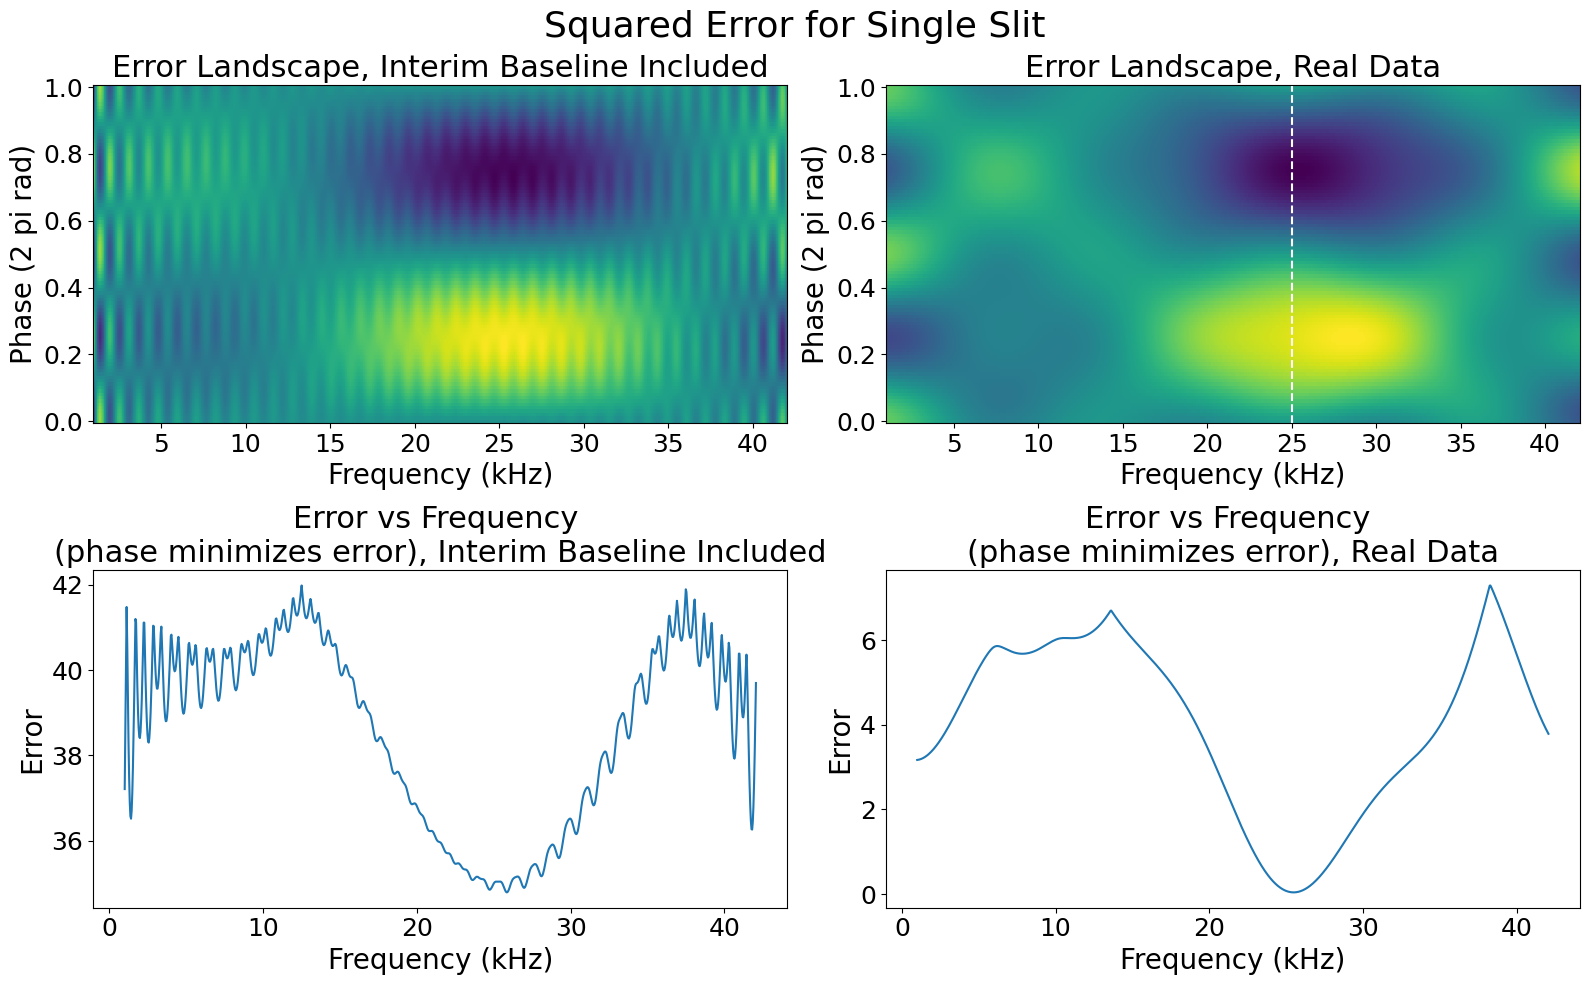

In [126]:

fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0][0].pcolormesh(gate_mesh[1]*1e-3, gate_mesh[0]/(2*np.pi), errors_gate_2d, shading='auto')
ax[0][0].set_title('Error Landscape, Interim Baseline Included')
ax[0][0].set_ylabel('Phase (2 pi rad)')
ax[0][0].set_xlabel('Frequency (kHz)')

ax[0][1].pcolormesh(data_mesh[1]*1e-3, data_mesh[0]/(2*np.pi), errors_data_2d,shading='auto')
ax[0][1].set_title('Error Landscape, Real Data')
ax[0][1].set_ylabel('Phase (2 pi rad)')
ax[0][1].set_xlabel('Frequency (kHz)')
# ax[0][1].set_xlim(22,28)
ax[0][1].axvline(25, color='white', linestyle='--')

ax[1][0].plot(freq_range*1e-3, errors_gate_1d)
ax[1][0].set_title('Error vs Frequency \n(phase minimizes error), Interim Baseline Included')
ax[1][0].set_ylabel('Error')
ax[1][0].set_xlabel('Frequency (kHz)')

ax[1][1].plot(freq_range*1e-3, errors_data_1d)
ax[1][1].set_title('Error vs Frequency \n(phase minimizes error), Real Data')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Frequency (kHz)')
# ax[1][1].set_xlim(22,28)

plt.suptitle('Squared Error for Single Slit', fontsize=26)
plt.tight_layout()

### Note: projected graph is smooth because phase wraps around at 2 pi to 0. Insensitive to inital guess, the current parameter vector can smoothly ride in one of the grooves all the way to the minimum error frequency and phase value. This is achieved by allowing phi to vary unbounded, not bounded to 0-2pi!
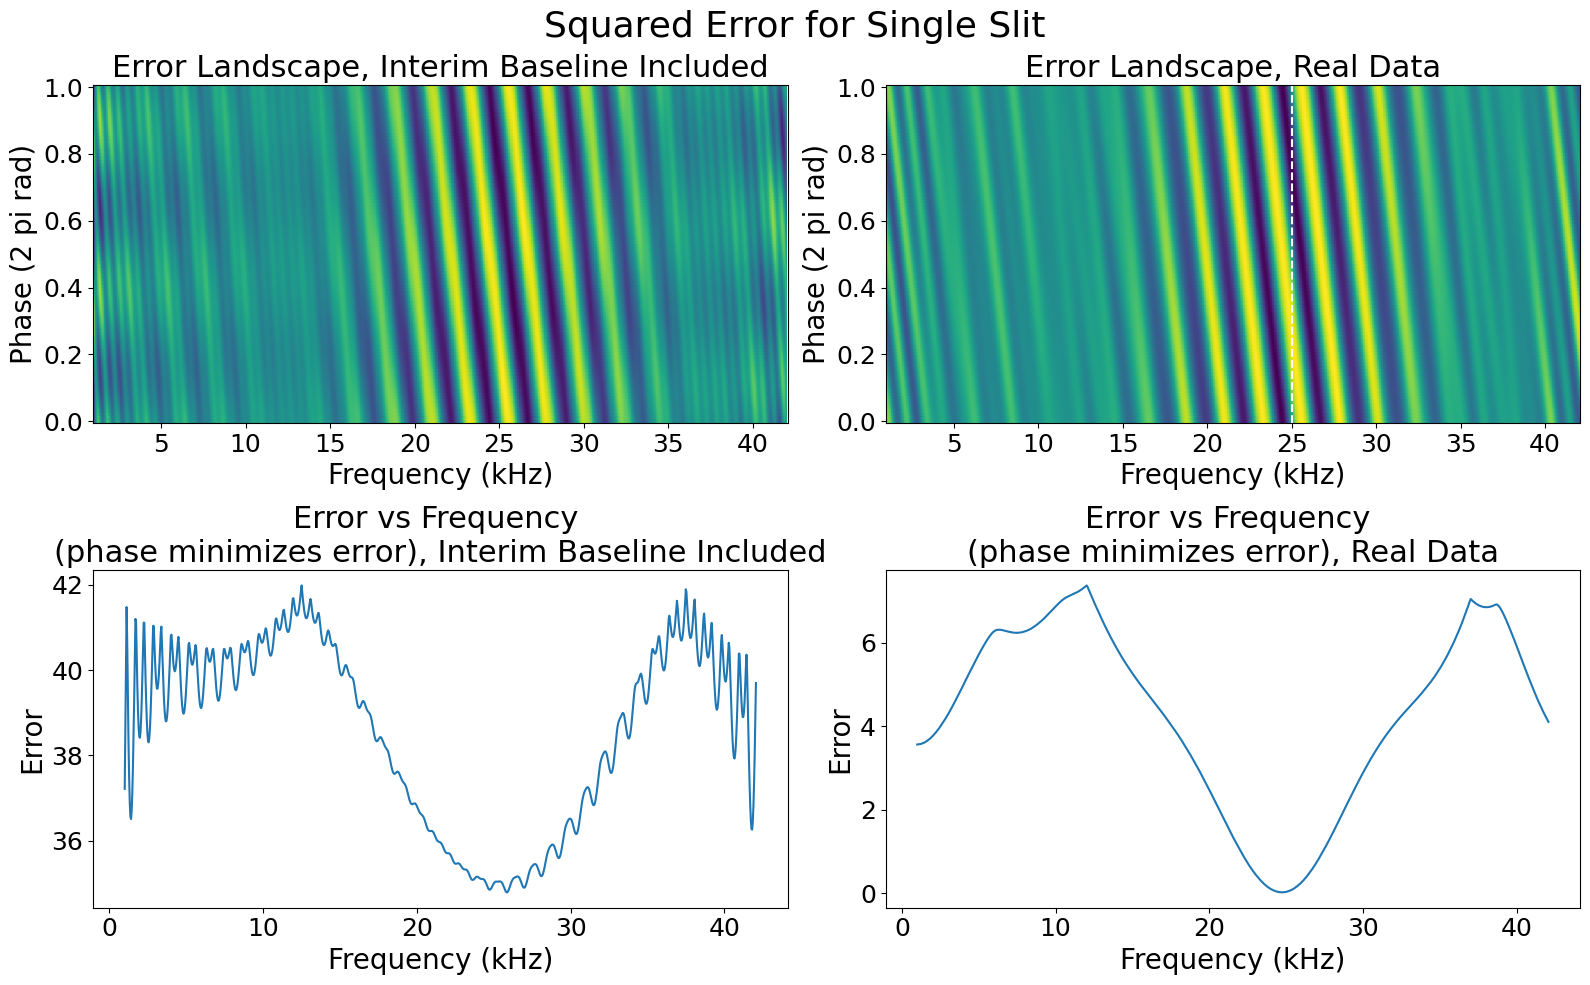

time domain size: 522, 522
dt: 0.01 ms, f_samp: 87.50 kHz, f_nyquist: 43.75 kHz
freq domain size: 261, 261


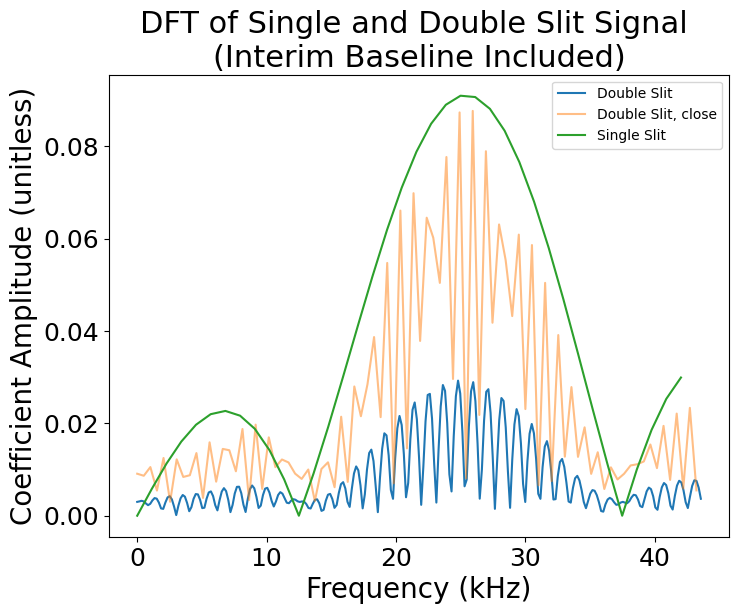

In [127]:
fft_gate2, freqs_gate2 = fourier_transform(t_2, data_2) 
fft_gate3, freqs_gate3 = fourier_transform(t_3, data_3)

print(f'time domain size: {data_2.size}, {t_2.size}')
print(f'dt: {(t_2[1]- t_2[0])*1e3:.2f} ms, f_samp: {1/(t_2[1]-t_2[0])*1e-3:.2f} kHz, f_nyquist: {0.5/(t_2[1]-t_2[0])*1e-3:.2f} kHz')
print(f'freq domain size: {fft_gate2.size}, {freqs_gate2.size}')

plt.plot(freqs_gate2*1e-3, fft_gate2, label='Double Slit')
plt.plot(freqs_gate3*1e-3, fft_gate3, label='Double Slit, close', alpha=0.5)
plt.plot(freqs_gate1*1e-3, fft_gate1, label='Single Slit')
plt.title('DFT of Single and Double Slit Signal \n(Interim Baseline Included)')
plt.ylabel('Coefficient Amplitude (unitless)')
plt.xlabel('Frequency (kHz)')
plt.legend()

In [128]:
phi_range2 = np.linspace(0, 2*np.pi, 100)
freq_range2 = np.linspace(1e3, freqs_gate2.max()-1e3, 1000)

print(phi_range2.size)
print(t_2.size)
print(freq_range2.size)

errors_gate_2d_2 = square_cos_error(t_2, data_2, freq_range2, phi_range2, want_2d=True)
gate_mesh2 = np.meshgrid(phi_range2, freq_range2)
errors_gate_1d_2 = square_cos_error(t_2, data_2, freq_range2, phi_range2, want_2d=False)

errors_data_2d_2 = square_cos_error(real_time2, real_data2, freq_range2, phi_range2, want_2d=True)
data_mesh2 = np.meshgrid(phi_range2, freq_range2)
errors_data_1d_2 = square_cos_error(real_time2, real_data2, freq_range2, phi_range2, want_2d=False)


100
522
1000


In [129]:
errors_gate_2d_3 = square_cos_error(t_3, data_3, freq_range2, phi_range2, want_2d=True)
gate_mesh3 = np.meshgrid(phi_range2, freq_range2)
errors_gate_1d_3 = square_cos_error(t_3, data_3, freq_range2, phi_range2, want_2d=False)

errors_data_2d_3 = square_cos_error(real_time3, real_data3, freq_range2, phi_range2, want_2d=True)
data_mesh3 = np.meshgrid(phi_range2, freq_range2)
errors_data_1d_3 = square_cos_error(real_time3, real_data3, freq_range2, phi_range2, want_2d=False)


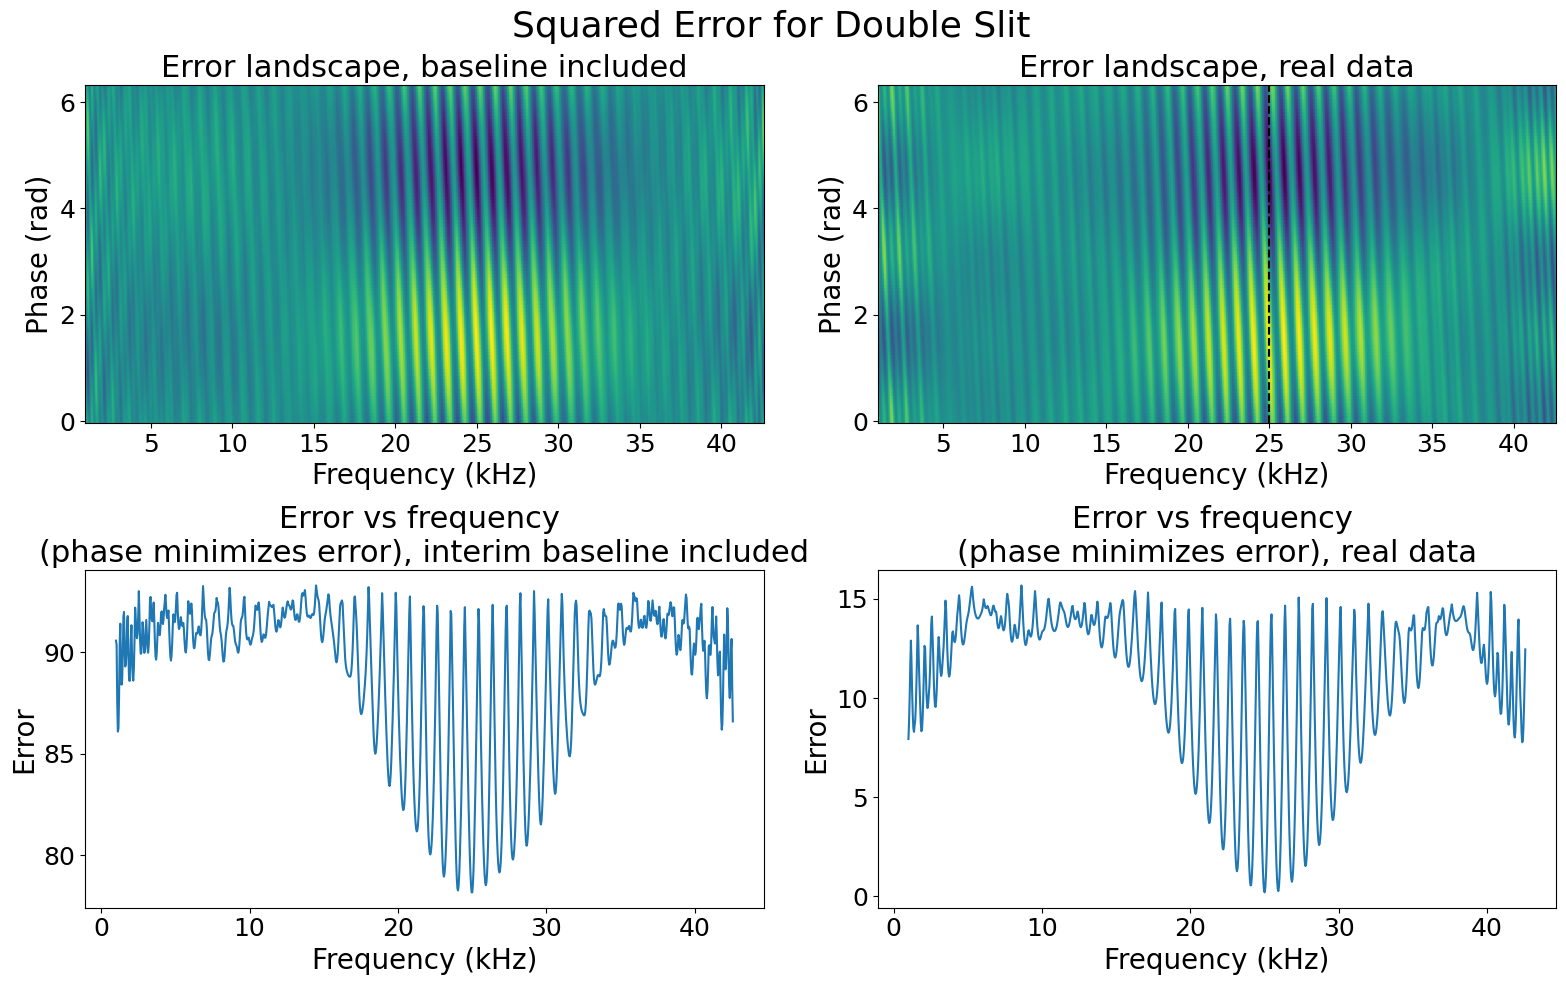

In [132]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0][0].pcolormesh(gate_mesh3[1]*1e-3, gate_mesh3[0], errors_gate_2d_3, shading='auto')
ax[0][0].set_title('Error landscape, baseline included')
ax[0][0].set_ylabel('Phase (rad)')
ax[0][0].set_xlabel('Frequency (kHz)')

ax[0][1].pcolormesh(data_mesh3[1]*1e-3, data_mesh3[0], errors_data_2d_3, shading='auto')
ax[0][1].set_title('Error landscape, real data')
ax[0][1].set_ylabel('Phase (rad)')
ax[0][1].set_xlabel('Frequency (kHz)')
ax[0][1].axvline(25, color='black', linestyle='--')

ax[1][0].plot(freq_range2*1e-3, errors_gate_1d_3)
ax[1][0].set_title('Error vs frequency \n(phase minimizes error), interim baseline included')
ax[1][0].set_ylabel('Error')
ax[1][0].set_xlabel('Frequency (kHz)')

ax[1][1].plot(freq_range2*1e-3, errors_data_1d_3)
ax[1][1].set_title('Error vs frequency \n(phase minimizes error), real data')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Frequency (kHz)')

plt.suptitle('Squared Error for Double Slit', fontsize=26)
plt.tight_layout()

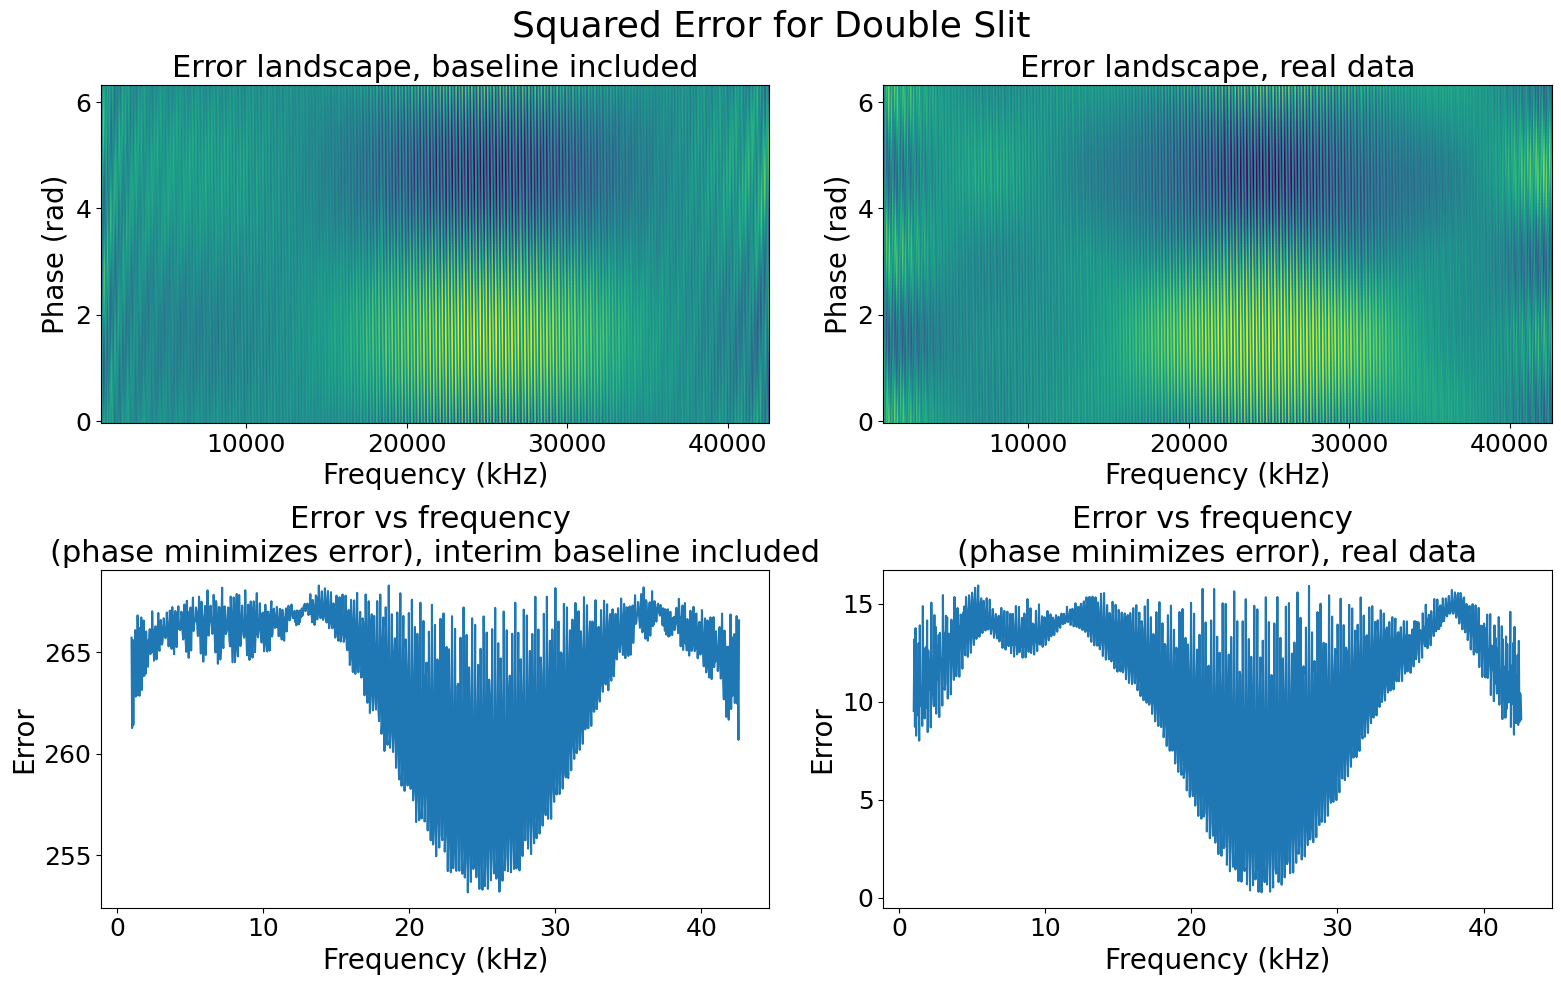

In [108]:
fig, ax = plt.subplots(2, 2, figsize=(16, 10))

ax[0][0].pcolormesh(gate_mesh2[1], gate_mesh2[0], errors_gate_2d_2, shading='auto')
ax[0][0].set_title('Error landscape, baseline included')
ax[0][0].set_ylabel('Phase (rad)')
ax[0][0].set_xlabel('Frequency (kHz)')

ax[0][1].pcolormesh(data_mesh2[1], data_mesh2[0], errors_data_2d_2, shading='auto')
ax[0][1].set_title('Error landscape, real data')
ax[0][1].set_ylabel('Phase (rad)')
ax[0][1].set_xlabel('Frequency (kHz)')

ax[1][0].plot(freq_range2*1e-3, errors_gate_1d_2)
ax[1][0].set_title('Error vs frequency \n(phase minimizes error), interim baseline included')
ax[1][0].set_ylabel('Error')
ax[1][0].set_xlabel('Frequency (kHz)')

ax[1][1].plot(freq_range2*1e-3, errors_data_1d_2)
ax[1][1].set_title('Error vs frequency \n(phase minimizes error), real data')
ax[1][1].set_ylabel('Error')
ax[1][1].set_xlabel('Frequency (kHz)')

plt.suptitle('Squared Error for Double Slit', fontsize=26)
plt.tight_layout()

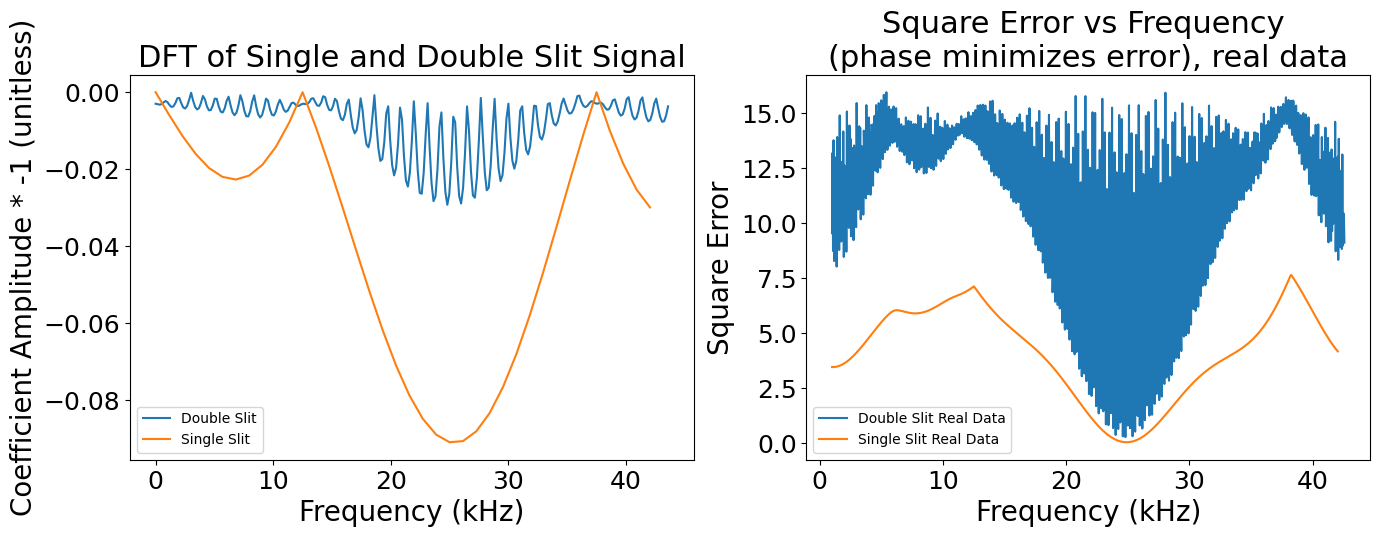

In [109]:
fig, ax = plt.subplots(1,2, figsize=(16, 5))
ax[0].plot(freqs_gate2*1e-3, fft_gate2*-1, label='Double Slit')
ax[0].plot(freqs_gate1*1e-3, fft_gate1*-1, label='Single Slit')
ax[0].set_title('DFT of Single and Double Slit Signal')
ax[0].set_ylabel('Coefficient Amplitude * -1 (unitless)')
ax[0].set_xlabel('Frequency (kHz)')
ax[0].legend()


ax[1].plot(freq_range2*1e-3, errors_data_1d_2, label='Double Slit Real Data')
ax[1].plot(freq_range*1e-3, errors_data_1d, label='Single Slit Real Data')
ax[1].set_title('Square Error vs Frequency \n(phase minimizes error), real data')
ax[1].set_ylabel('Square Error')
ax[1].set_xlabel('Frequency (kHz)')
ax[1].legend()



In [110]:
real_dft1_max = freqs_data1[np.argmax(fft_data1)]
dft_1_max = freqs_gate1[np.argmax(fft_gate1)]
dft_2_max = freqs_gate2[np.argmax(fft_gate2)]
sqr_err_min1 = freq_range[np.argmin(errors_data_1d)]
sqr_err_min2 = freq_range2[np.argmin(errors_data_1d_2)]


print(f'True Frequency: {f_0*1e-3} kHz')

print(f'Real DFT Frequency (Single Slit): {real_dft1_max*1e-3:.2f} kHz')

print(f'Max DFT Frequency, [With Interim] (Single Slit, not feasible with real data): {dft_1_max*1e-3:.2f} kHz')
print(f'Max DFT Frequency, [With Interim] (Double Slit, not feasible with real data): {dft_2_max*1e-3:.2f} kHz')

print(f'Min Square Error (Single Slit, real data): {sqr_err_min1*1e-3:.2f} kHz')
print(f'Min Square Error (Double Slit, real data): {sqr_err_min2*1e-3:.2f} kHz')

True Frequency: 25.0 kHz
Real DFT Frequency (Single Slit): 21.88 kHz
Max DFT Frequency, [With Interim] (Single Slit, not feasible with real data): 25.00 kHz
Max DFT Frequency, [With Interim] (Double Slit, not feasible with real data): 24.81 kHz
Min Square Error (Single Slit, real data): 24.91 kHz
Min Square Error (Double Slit, real data): 24.81 kHz


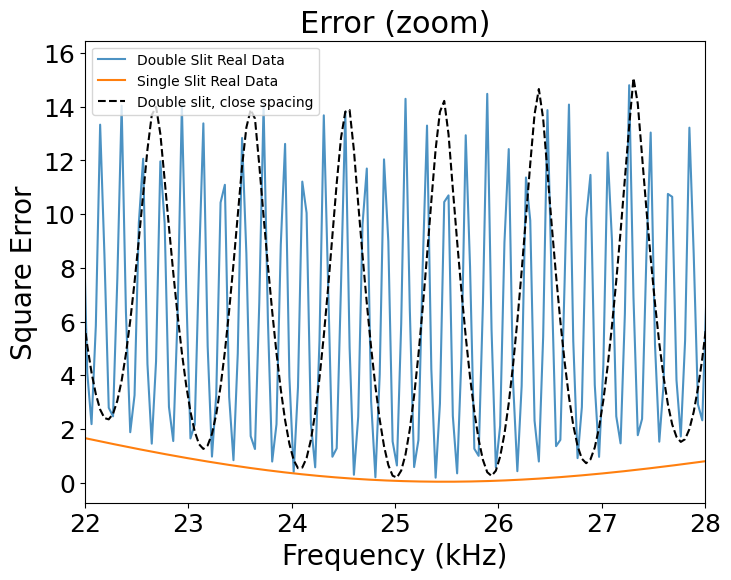

In [146]:
plt.plot(freq_range2*1e-3, errors_data_1d_2, label='Double Slit Real Data', alpha=0.8)
plt.plot(freq_range*1e-3, errors_data_1d, label='Single Slit Real Data')
plt.plot(freq_range2*1e-3, errors_data_1d_3, linestyle='--', label='Double slit, close spacing', color='black')
plt.xlim(22,28)
plt.title('Error (zoom)')
plt.xlabel('Frequency (kHz)')
plt.ylabel('Square Error')
plt.legend()

How to make fitting converge (phase instability)

Fitted frequency: 25.000000000348376 +- 1.2341179185947826e-09 kHz
Fitted phase: -1.0000000004231848 pi +- 1.093651119248381e-09 pi rad
Fitted amplitude: -1.00 +- 0.00
Fitted offset: 0.00 +- 0.00


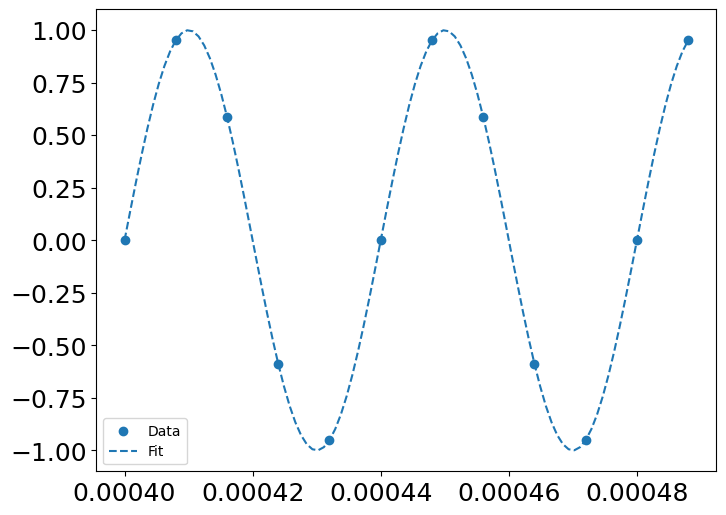

In [54]:
from scipy.optimize import curve_fit

def sin_func(x, A, A_0, f, phi):
    return A * np.sin(2 * np.pi * f * x + phi) + A_0


initial_guess = [1, 0, 24e3, 0]
x_data = real_time1 
y_data = real_data1
popt, pcov = curve_fit(sin_func, x_data, y_data, p0=initial_guess)
print(f'Fitted frequency: {popt[2]*1e-3} +- {np.sqrt(pcov[2, 2])*1e-3} kHz')
print(f'Fitted phase: {popt[3]/np.pi} pi +- {np.sqrt(pcov[3, 3])/np.pi} pi rad')
print(f'Fitted amplitude: {popt[0]:.2f} +- {np.sqrt(pcov[0, 0]):.2f}')
print(f'Fitted offset: {popt[1]:.2f} +- {np.sqrt(pcov[1, 1]):.2f}')
plt.scatter(x_data, y_data, label='Data')
x_range = np.linspace(x_data[0], x_data[-1], 100)
plt.plot(x_range, sin_func(x_range, *popt), label='Fit', linestyle='--')
plt.legend()